# Oscilators

<!-- @import "[TOC]" {cmd="toc" depthFrom=1 depthTo=6 orderedList=false} -->

Moving Average Convergence Divergence (MACD) or Absolute Price Oscillator (APO)- Calculates the difference between two moving averages to identify momentum and trend changes. 
* Pros: Good for identifying momentum shifts. 
* Cons: Can generate false signals in choppy markets.

Attributes:
* APO is an absolute momentum oscillator while MACD is a relative momentum oscillator. APO is better for identifying trend changes while MACD is better for gauging acceleration. 
* APO is less prone to false signals since it uses raw price.
* APO oscillates around zero.
* MACD has no fixed center line and oscillates based on its input data.

Relative Strength Index (RSI) - Compares the magnitude of recent gains and losses to identify overbought and oversold conditions. 
Pros: Good for identifying divergences and potential reversals. 
Cons: Can stay overbought or oversold for long periods.

Stochastic Oscillator - Compares a security's closing price to its price range over a set period. 
Pros: Useful for identifying overbought/oversold levels. 
Cons: Can produce false signals and whipsaws.

## Prepare your Environment

Have a jupyter environment ready, and `pip install` these libraries:
- numpy
- pandas
- yfinance


In [106]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import os

import dotenv
%load_ext dotenv

IS_KAGGLE = os.getenv('IS_KAGGLE', 'True') == 'True'

if IS_KAGGLE:
    # Kaggle confgs
    print('Running in Kaggle...')
    %pip install yfinance
    %pip install statsmodels
    %pip install seaborn
    %pip install itertools
    %pip install scikit-learn

    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
else:
    print('Running Local...')

import yfinance as yf

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv
Running Local...


In [107]:
import pandas as pd


def load_ticker_ts_df(ticker, start_date, end_date):
    """
    Load and cache time series financial data from Yahoo Finance API.
    Parameters:
    - ticker (str): The stock ticker symbol (e.g., 'AAPL' for Apple Inc.).
    - start_date (str): The start date in 'YYYY-MM-DD' format for data retrieval.
    - end_date (str): The end date in 'YYYY-MM-DD' format for data retrieval.
    Returns:
    - df (pandas.DataFrame): A DataFrame containing the financial time series data.

    """
    dir_path = './data'
    cached_file_path = f'{dir_path}/{ticker}_{start_date}_{end_date}.pkl'
    try:
        if os.path.exists(cached_file_path):
            df = pd.read_pickle(cached_file_path)
        else:
            df = yf.download(ticker, start=start_date, end=end_date)
            if not os.path.exists(dir_path):
                os.makedirs(dir_path)
            df.to_pickle(cached_file_path)
    except FileNotFoundError:
        print(
            f'Error downloading and caching or loading file with ticker: {ticker}')

    return df


def calculate_profit(signals, prices):
    """
    Calculate cumulative profit based on trading signals and stock prices.
    Parameters:
    - signals (pandas.DataFrame): A DataFrame containing trading signals (1 for buy, -1 for sell).
    - prices (pandas.Series): A Series containing stock prices corresponding to the signal dates.
    Returns:
    - cum_profit (pandas.Series): A Series containing cumulative profit over time.
    """
    profit = pd.Series(index=prices.index)
    profit.fillna(0, inplace=True)

    buys = signals[signals['orders'] == 1].index
    sells = signals[signals['orders'] == -1].index
    skip = 0
    for bi in buys:
        if skip > 0:
            skip -= 1
            continue
        sis = sells[sells > bi]
        if len(sis) > 0:
            si = sis[0]
            profit[si] = prices[si] - prices[bi]
            skip = len(buys[(buys > bi) & (buys < si)])
        else:
            profit[-1] = prices[-1] - prices[bi]
    cum_profit = profit.cumsum()

    return cum_profit


def plot_strategy(prices_df, signal_df, profit):
    """
    Plot a trading strategy with buy and sell signals and cumulative profit.
    Parameters:
    - prices (pandas.Series): A Series containing stock prices.
    - signals (pandas.DataFrame): A DataFrame with buy (1) and sell (-1) signals.
    - profit (pandas.Series): A Series containing cumulative profit over time.
    Returns:
    - ax1 (matplotlib.axes.Axes): The top subplot displaying stock prices and signals.
    - ax2 (matplotlib.axes.Axes): The bottom subplot displaying cumulative profit.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': (3, 1)},
                                   figsize=(24, 12))

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price in $')
    ax1.plot(prices_df.index, prices_df, color='g', lw=0.25)

    # Plot the Buy and Sell signals
    ax1.plot(signal_df.loc[signal_df.orders == 1.0].index,
             prices_df[signal_df.orders == 1.0],
             '^', markersize=12, color='blue', label='Buy')
    ax1.plot(signal_df.loc[signal_df.orders == -1.0].index,
             prices_df[signal_df.orders == -1.0],
             'v', markersize=12, color='red', label='Sell')

    ax2.plot(profit.index, profit, color='b')
    ax2.set_ylabel('Cumulative Profit (%)')
    ax2.set_xlabel('Date')

    return ax1, ax2

In [108]:
tickers = ['AAPL']

START_DATE = '2021-01-01'
END_DATE = '2023-10-31'
APO_BULL_SIGNAL = 5
APO_BEAR_SIGNAL = -5
APO_FAST_WINDOW = 12
APO_SLOW_WINDOW = 45

ticker = load_ticker_ts_df('AAPL', START_DATE, END_DATE)

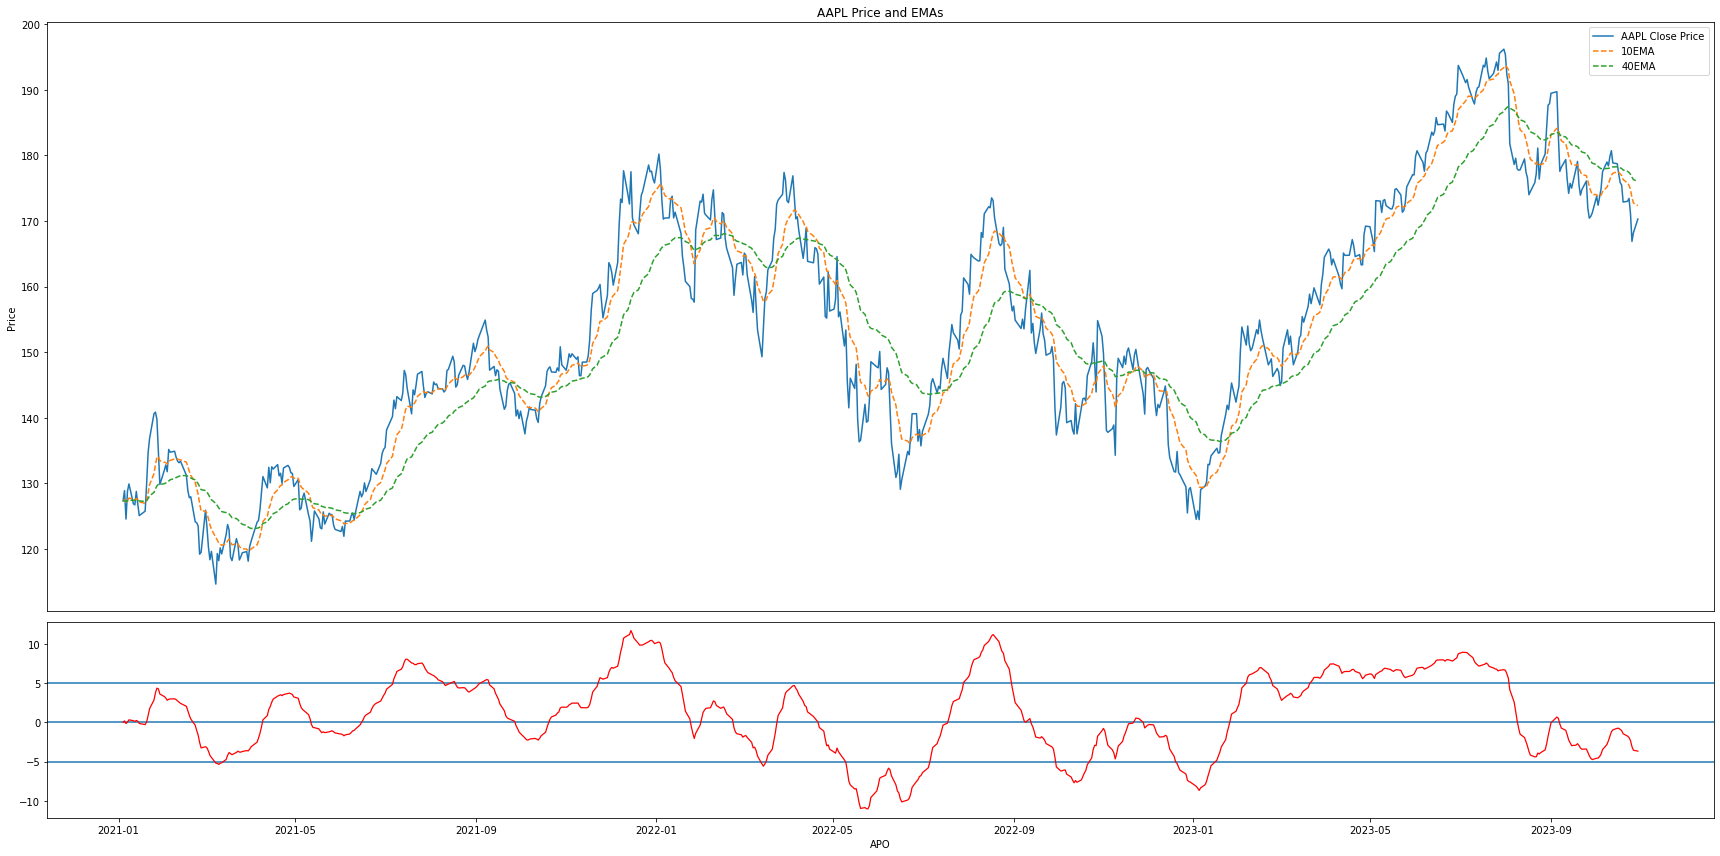

In [109]:
ticker['10EMA'] = ticker['Adj Close'].ewm(
    span=APO_FAST_WINDOW, adjust=False).mean()
ticker['40EMA'] = ticker['Adj Close'].ewm(
    span=APO_SLOW_WINDOW, adjust=False).mean()
ticker['APO'] = ticker['10EMA'] - ticker['40EMA']

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={
    'height_ratios': (3, 1)}, figsize=(24, 12))
ax1.plot(ticker.index, ticker['Adj Close'], label='AAPL Close Price')
ax1.plot(ticker.index, ticker['10EMA'], label='10EMA', linestyle='--')
ax1.plot(ticker.index, ticker['40EMA'], label='40EMA', linestyle='--')

ax2.axhline(APO_BULL_SIGNAL)
ax2.axhline(0.0)
ax2.axhline(APO_BEAR_SIGNAL)
ax2.plot(ticker.index, ticker['APO'], label='40EMA', lw=1.25, color='r')
ax1.set_title('AAPL Price and EMAs')
ax2.set_xlabel('APO')
ax1.set_ylabel('Price')
ax1.set_xticks([])

ax1.legend()
plt.tight_layout()
plt.show()

# The Components of an APO

1. **Exponential Moving Average (EMA):** A moving average that gives more weight to recent data point:

$$EMA(n) = (Close - EMA(previous, n)) \cdot \frac{2}{n + 1} + EMA(previous, n)$$


1. **10-day EMA (MPA 10):** Moving Price Average with a 10-day period. Reacts quickly to short-term price changes, sensitive to recent market developments.

2. **40-day EMA (MPA 40):** Moving Price Average with a 40-day period. Provides a longer-term view of price trends.

The crossover of a fast EMA above a slow EMA can signal a bullish trend, while the opposite can indicate a bearish trend. 

C:\Users\worker\AppData\Local\Temp/ipykernel_8216/2469157941.py:41: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  profit = pd.Series(index=prices.index)


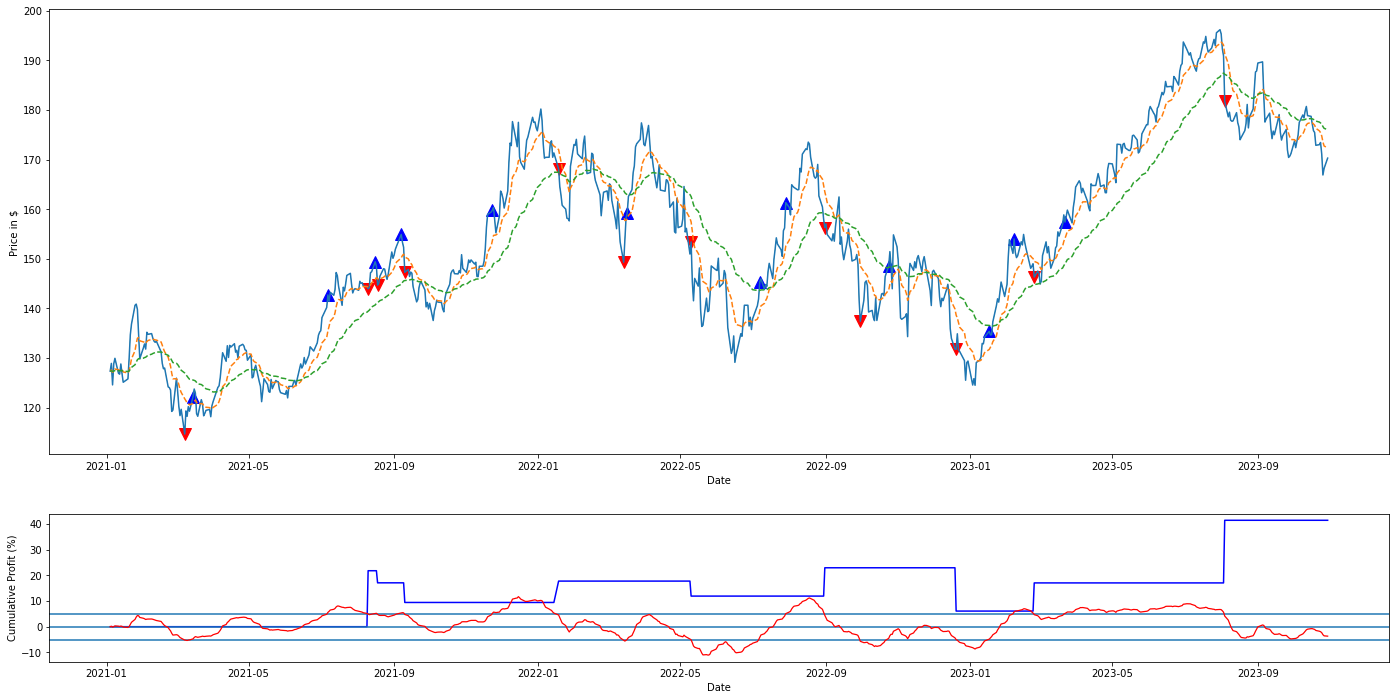

In [111]:
import pandas as pd


def signal_apo_oscillator(ticker_ts, fast_window_size=APO_FAST_WINDOW, slow_window_size=APO_SLOW_WINDOW, buy_threshold=APO_BULL_SIGNAL, sell_threshold=APO_BEAR_SIGNAL):
    fema = ticker_ts['Adj Close'].ewm(
        span=fast_window_size, adjust=False).mean()
    sma = ticker_ts['Adj Close'].ewm(
        span=slow_window_size, adjust=False).mean()
    apo = fema - sma

    signals_df = pd.DataFrame(index=ticker_ts.index)
    signals_df['signal'] = np.where(
        apo >= buy_threshold, 1, np.where(apo <= sell_threshold, -1, 0))
    signals_df['orders'] = signals_df['signal'].diff()
    signals_df.loc[signals_df['orders'] == 0, 'orders'] = None
    return signals_df


signals_df = signal_apo_oscillator(ticker)
profit_series = calculate_profit(signals_df, ticker["Adj Close"])
ax1, ax2 = plot_strategy(ticker["Adj Close"], signals_df, profit_series)
ax1.plot(ticker.index, ticker['Adj Close'], label='AAPL Close Price')
ax1.plot(ticker.index, ticker['10EMA'], label='10EMA', linestyle='--')
ax1.plot(ticker.index, ticker['40EMA'], label='40EMA', linestyle='--')

plt.show()

# Conclusion

These EMAs help filter out noise in price data and provide a clearer picture of price trends, making them valuable tools in technical analysis and trading decisions.

## References



## Github

Article here is also available on [Github]()

Kaggle notebook available [here]()


## Media

All media used (in the form of code or images) are either solely owned by me, acquired through licensing, or part of the Public Domain and granted use through Creative Commons License.

## CC Licensing and Use

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.